In [20]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from util_analysis import *

Primero parseamos los datos que obtenemos del output para que sea más cómodo

In [21]:
df = fetch_sim_data('exp1')
df

Processing file exp1-tol-cons-1-15
Processing file exp1-tol-cons-5-15
Processing file exp1-tol-cons-1-5
Processing file exp1-tol-cons-10-5
Processing file exp1-tol-cons-10-15
Processing file exp1-tol-cons-5-5


,time,file,sun_radiation,sun_degree,obtained_energy,consumed_energy,battery
0,00:06:00:000:0,exp1-tol-cons-1-15,6.17000,-35.01000,0.00000,0.00000,0.00000
1,00:12:00:000:0,exp1-tol-cons-1-15,6.17000,-35.19000,0.00000,0.00000,0.00000
2,00:18:00:000:0,exp1-tol-cons-1-15,6.17000,-35.34000,0.00000,0.00000,0.00000
3,00:24:00:000:0,exp1-tol-cons-1-15,6.17000,-35.46000,0.00000,0.00000,0.00000
4,00:30:00:000:0,exp1-tol-cons-1-15,6.17000,-35.53000,0.00000,0.00000,0.00000
5,00:36:00:000:0,exp1-tol-cons-1-15,6.17000,-35.57000,0.00000,0.00000,0.00000
6,00:42:00:000:0,exp1-tol-cons-1-15,6.17000,-35.58000,0.00000,0.00000,0.00000
7,00:48:00:000:0,exp1-tol-cons-1-15,6.17000,-35.54000,0.00000,0.00000,0.00000
8,00:54:00:000:0,exp1-tol-cons-1-15,6.17000,-35.47000,0.00000,0.00000,0.00000
9,01:00:00:000:0,exp1-tol-cons-1-15,6.17000,-35.36000,0.00000,0.00000,0.00000


Primero analizamos el comportamiento del sol

In [22]:
df['sun_degree'] = df['sun_degree'].apply(lambda x: float(x))
df['sun_radiation'] = df['sun_radiation'].apply(lambda x: float(x))

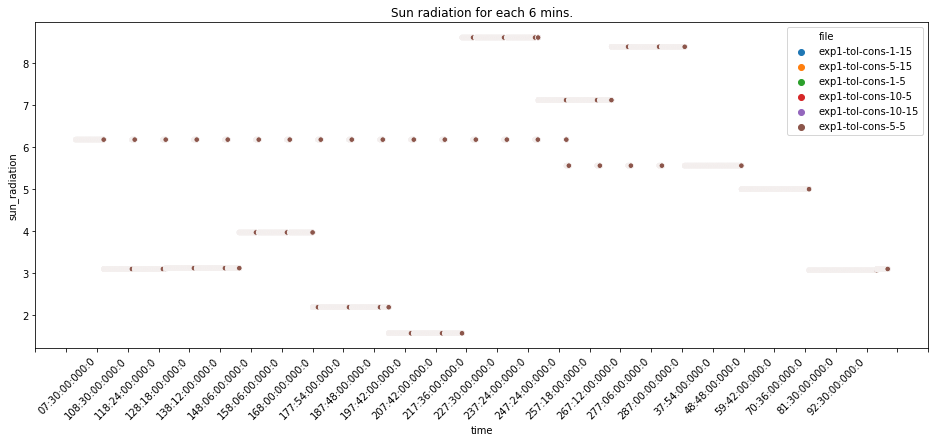

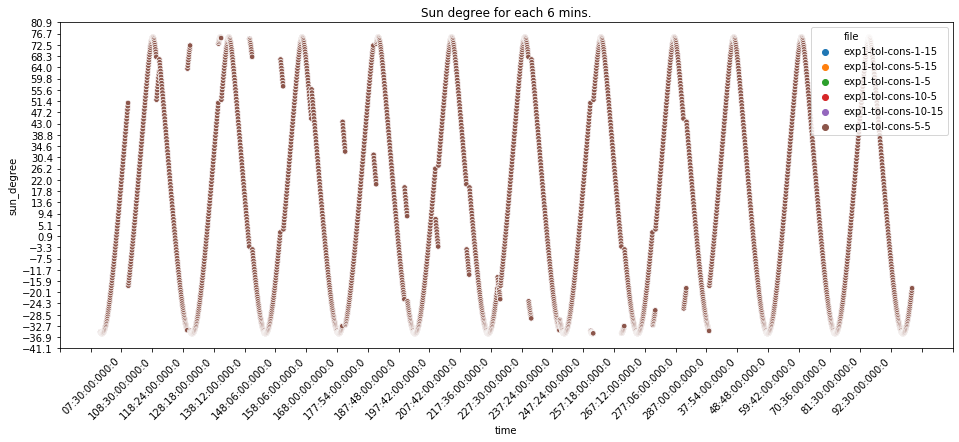

In [23]:
plt.figure(figsize=(16, 6))
ax1 = sns.scatterplot(x='time', y='sun_radiation',data=df, hue='file', s=30)
ax1.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun radiation for each 6 mins.")
plt.show()

plt.figure(figsize=(16, 6))
ax2 = sns.scatterplot(x='time', y='sun_degree',data=df, hue='file', s=30)
ax2.xaxis.set_major_locator(ticker.LinearLocator(30))
ax2.yaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Sun degree for each 6 mins.")
plt.show()

Ahora analizamos la energía neta obtenida. Para ello, agregamos una columna con las energía neta obtenida en cada instante

In [24]:
obtained_energies =df['obtained_energy'].apply(lambda x: float(x))
consumed_energies = df['consumed_energy'].apply(lambda x: float(x))
df['net_obtained_energy'] = obtained_energies - consumed_energies

In [25]:
def valor_de_param(y):
    return float(y.split('-')[-1])


files_ordenados = sorted(df['file'].unique(), key=valor_de_param)

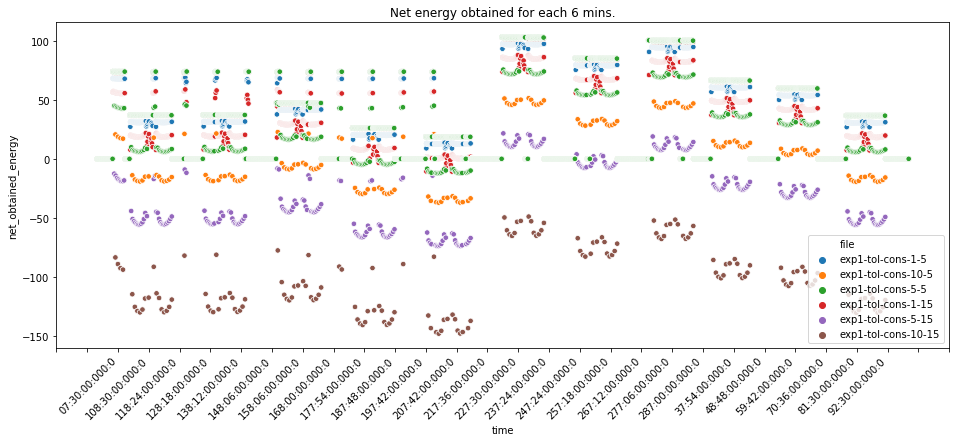

In [26]:
plt.figure(figsize=(16, 6))

ax3 = sns.scatterplot(x='time', y='net_obtained_energy',data=df, hue='file', hue_order=files_ordenados, s=30)
ax3.xaxis.set_major_locator(ticker.LinearLocator(30))
plt.xticks(rotation=45, ha='right')
plt.title("Net energy obtained for each 6 mins.")
plt.show()

Ahora analizamos los resultados al final de la simulación.
Tomamos el último valor de la batería en cada una, que nos dice cuanta energía neta se acumuló en total.

In [27]:
batteries = df.groupby('file')['battery'].last().reset_index()
batteries['battery'] = batteries['battery'].apply(lambda x: float(x))
batteries

,file,battery
0,exp1-tol-cons-1-15,24220.67852
1,exp1-tol-cons-1-5,30211.27894
2,exp1-tol-cons-10-15,24044.63710
3,exp1-tol-cons-10-5,30015.23708
4,exp1-tol-cons-5-15,24607.44030
5,exp1-tol-cons-5-5,30296.44064


Text(0.5, 1.0, 'Total net energy obtained')

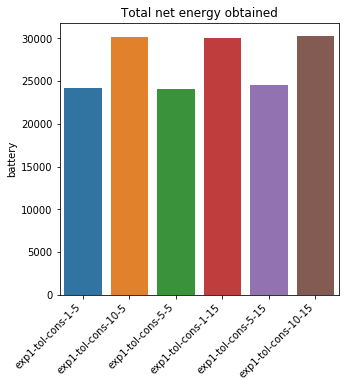

In [28]:
plt.figure(figsize=(5, 5))

ax4 = sns.barplot(x=files_ordenados, y='battery', data=batteries)
plt.xticks(rotation=45, ha='right')
plt.title("Total net energy obtained")